# Import qbiome

In [21]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis
from qbiome.qutil import customDataFormatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
plt.style.use('ggplot')

from qbiome.qutil import qplot
from qbiome.qutil import qsmooth

%load_ext autoreload
%autoreload 2
%reload_ext qbiome.qutil
%reload_ext qbiome.forecaster


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data and initialization

In [2]:
dirname = 'example_data/'
data = '../../infbiome_/data/HC/hc_Phylum_GTDB_denoised_filtered_percent.csv'
meta = dirname + 'hc_metadata.csv'
BIOMES=None
BIOMES=['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'Fusobacteriota']

data,property_map=customDataFormatter(data,meta,
                        META_PROP=['hc', 'HCZ', 'sex', 'hc_Birth',
           'HCZ_Birth', 'hc_Discharge', 'HCZ_Discharge',
           'HCZ_discharge_birth_difference', 'HCZ_Category',
           'HCZ_difference_Category', 'NEC', 'IVH', 'ROP', 'BPD', 'Infection',
           'total_Morbidities', 'Morbidity_Category', 'TIMPS score',
           'TIMPS z-score', 'TIMPS Category'],
                        COL_SELECT={"Samples": "sample_id", "PTID": "subject_id", "PMA":"week"},
                                      BIOMES=BIOMES)

data_=data.assign(source='gnd')
quantizer = Quantizer(num_levels=6)
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [3]:
data

,sample_id,variable,value,subject_id,week
0,100001.c.062,Actinobacteriota,0.000000,100001,34
1,100001.c.062,Bacteroidota,0.677740,100001,34
2,100001.c.062,Firmicutes,3.005389,100001,34
3,100001.c.062,Proteobacteria,66.657408,100001,34
4,100001.c.062,Fusobacteriota,0.000000,100001,34
...,...,...,...,...,...
665,100091.c.053,Actinobacteriota,0.619998,100091,31
666,100091.c.053,Bacteroidota,4.385075,100091,31
667,100091.c.053,Firmicutes,0.247999,100091,31
668,100091.c.053,Proteobacteria,86.190959,100091,31


In [4]:
BIOMES=list(data.variable.value_counts().index.values)
BIOMES

['Actinobacteriota',
 'Firmicutes',
 'Bacteroidota',
 'Fusobacteriota',
 'Proteobacteria']

# Train qnet

In [5]:
%%time
NUMQ=1
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator.train_qnet(
        features, label_matrix, alpha=0.3, min_samples_split=2, 
        out_fname=None)
    qnet_orchestrator.save_qnet('data1_phylum_'+str(i)+'.joblib')
    #qnet_orchestrator.load_qnet('data1.joblib')

100%|██████████| 1/1 [00:03<00:00,  3.64s/it]

CPU times: user 1.67 s, sys: 213 ms, total: 1.89 s
Wall time: 3.64 s


# Generate tree files

In [6]:
outdirname = 'dotfiles_1_phylum_'
import os
if not os.path.isdir(outdirname):
    os.makedirs(outdirname)
for f in os.listdir(outdirname):
    os.remove(os.path.join(outdirname, f))    
qnet_orchestrator.export_qnet_tree_dotfiles(outdirname)

! cd 'dotfiles_1_phylum_'; for i in `ls *dot`; do dot -Tpng $i -o ${i/dot/png}; done >& \dev\null

76


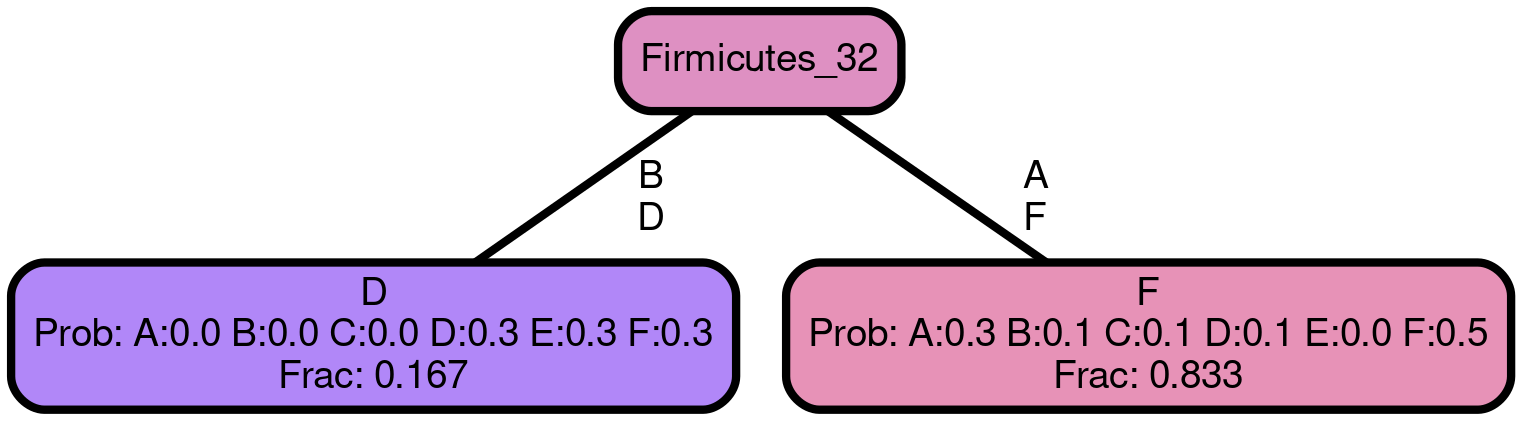

In [7]:
! ls -lhS dotfiles_1_phylum_/*png | wc -l

from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='dotfiles_1_phylum_/Proteobacteria_32.png')

# Generate hypotheses

In [8]:
hypothesis = Hypothesis(quantizer=quantizer, model_path=outdirname, 
                        detailed_labels=True)

hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=27, time_end=34)
hypothesis.to_dot('hypothesis_phylum_30_34_-2.dot')
hypothesis.hypotheses.sort_values('src')

100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


,src,tgt,time_tgt,lomar,pvalue
0,Actinobacteriota,Firmicutes,28.0,1.022551e+00,0.000000e+00
11,Actinobacteriota,Actinobacteriota,30.0,4.197963e-01,0.000000e+00
30,Actinobacteriota,Proteobacteria,28.0,-9.324389e+00,0.000000e+00
31,Actinobacteriota,Proteobacteria,31.0,4.741003e+00,0.000000e+00
19,Actinobacteriota,Bacteroidota,34.0,1.337021e-01,1.973627e-149
3,Actinobacteriota,Firmicutes,33.0,7.584003e-02,5.643644e-66
2,Actinobacteriota,Firmicutes,31.0,-5.797066e-01,0.000000e+00
1,Actinobacteriota,Firmicutes,30.0,2.183683e+00,0.000000e+00
32,Bacteroidota,Proteobacteria,31.0,5.271194e-01,0.000000e+00
20,Bacteroidota,Bacteroidota,31.0,6.014768e-02,0.000000e+00


# Forecast microbiome evolution

In [9]:
%%time
# forecast from time SW
SW=29
qnet_orchestrator = QnetOrchestrator(quantizer)
qnet_orchestrator.load_qnet('data1_phylum_'+str(i)+'.joblib')
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(
    label_matrix, 
    start_week=SW).assign(source='forecasted')
    

CPU times: user 11.7 s, sys: 67.9 ms, total: 11.8 s
Wall time: 11.7 s


In [10]:
label_matrix.shape

(39, 95)

In [11]:
#forecasted_dict[0]
DF=forecasted_
SUBJECTS=DF.subject_id.value_counts().index.values
DF

,subject_id,variable,week,value,source
0,100001,Actinobacteriota,24,NaN,forecasted
1,100002,Actinobacteriota,24,NaN,forecasted
2,100003,Actinobacteriota,24,NaN,forecasted
3,100004,Actinobacteriota,24,NaN,forecasted
4,100005,Actinobacteriota,24,NaN,forecasted
...,...,...,...,...,...
3700,100078,Proteobacteria,43,78.982302,forecasted
3701,100083,Proteobacteria,43,78.595107,forecasted
3702,100084,Proteobacteria,43,78.982302,forecasted
3703,100090,Proteobacteria,43,78.595107,forecasted


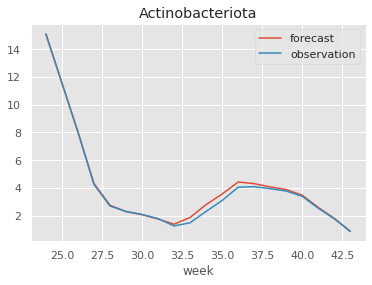

In [12]:
DF_pop=DF.groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)
DF_data=data.groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)

DF_pop_smooth=qsmooth(DF_pop,index='week',
                      columns='variable',
                      normalize=False,
                      interpolate=False,lowess_fraction=.4)

#DF_data_smooth
DF_data_smooth=qsmooth(DF_data,index='week',
                       columns='variable',
                       normalize=False,
                       interpolate=False,lowess_fraction=.4)


ax=DF_pop_smooth.Actinobacteriota.plot(label='forecast')
DF_data_smooth.Actinobacteriota.plot(ax=ax,label='observation')
ax.set_title('Actinobacteriota')
ax.legend();

In [13]:
data.subject_id.value_counts()

100052    55
100041    50
100001    45
100004    30
100012    30
100003    25
100011    25
100051    25
100016    25
100058    20
100053    20
100064    20
100063    20
100014    20
100083    15
100015    15
100054    15
100055    15
100005    15
100068    15
100050    15
100084    10
100078    10
100075    10
100069    10
100066    10
100091    10
100062    10
100061    10
100060    10
100057    10
100002    10
100036    10
100010    10
100065     5
100070     5
100076     5
100090     5
100056     5
Name: subject_id, dtype: int64

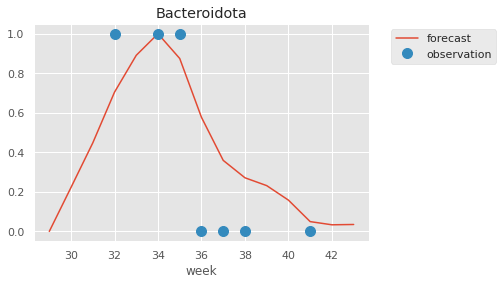

In [14]:
SID=100075
DF_pop=DF[DF.subject_id==SID].groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)
DF_data=data[DF.subject_id==SID].groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)
DF_pop_smooth=qsmooth(DF_pop,index='week',
                      columns='variable',
                      normalize=True,
                      interpolate=False,lowess_fraction=.4)

#DF_data_smooth
DF_data_smooth=qsmooth(DF_data,index='week',
                       columns='variable',
                       normalize=True,
                       interpolate=False,lowess_fraction=.4)

var='Bacteroidota'
ax=DF_pop_smooth[var].plot(label='forecast')
DF_data_smooth[var].plot(ax=ax,style='o',ms=10,label='observation')
ax.set_title('Bacteroidota')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

## Forecast data for a new patient

+ Read in new data, quantize, and forecast

In [15]:
new_subject = pd.DataFrame({
    'week': [SW] * len(BIOMES),
    'variable': BIOMES,
    'value': np.random.rand(len(BIOMES))
})

new_subject.to_csv('new_subject.csv',index=None)
new_subject=pd.read_csv('new_subject.csv')
display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=29
)

,week,variable,value
0,29,Actinobacteriota,0.048500
1,29,Firmicutes,0.715491
2,29,Bacteroidota,0.847346
3,29,Fusobacteriota,0.840039
4,29,Proteobacteria,0.826743


In [16]:
new_subject_quantized

,subject_id,Actinobacteriota_24,Actinobacteriota_26,Actinobacteriota_27,Actinobacteriota_28,Actinobacteriota_29,Actinobacteriota_30,Actinobacteriota_31,Actinobacteriota_32,Actinobacteriota_33,...,Proteobacteria_34,Proteobacteria_35,Proteobacteria_36,Proteobacteria_37,Proteobacteria_38,Proteobacteria_39,Proteobacteria_40,Proteobacteria_41,Proteobacteria_42,Proteobacteria_43
0,12345,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
new_subject_matrix.shape

(1, 95)

In [20]:
new_subject_forecasted#.subject_id.value_counts()#[new_subject_forecasted.subject_id==12345]

,subject_id,variable,week,value
0,100001,Actinobacteriota,24,NaN
1,100002,Actinobacteriota,24,NaN
2,100003,Actinobacteriota,24,NaN
3,100004,Actinobacteriota,24,NaN
4,100005,Actinobacteriota,24,NaN
...,...,...,...,...
3700,100078,Proteobacteria,43,NaN
3701,100083,Proteobacteria,43,NaN
3702,100084,Proteobacteria,43,NaN
3703,100090,Proteobacteria,43,NaN


In [ ]:
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
new_subject=pd.read_csv('new_subject_001.csv')
#display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1011')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster_i.forecast_data(
    new_subject_matrix, 
    start_week=29
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
new_subject=pd.read_csv('new_subject_002.csv')
#display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1012')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster_i.forecast_data(
    new_subject_matrix, 
    start_week=29
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')